## Importing the necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Average 
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing import image

## Getting the path of the training and testing data of the cell image dataset

In [2]:
dataset_directory_location = 'cell_images'

In [3]:
os.listdir(dataset_directory_location)

['test', 'train']

In [4]:
train_dataset_location = os.path.join(dataset_directory_location, 'train')
test_dataset_location = os.path.join(dataset_directory_location, 'test')

In [5]:
os.listdir(train_dataset_location)

['parasitized', 'uninfected']

In [6]:
os.listdir(test_dataset_location)

['parasitized', 'uninfected']

## Viewing a cell image

In [7]:
cell_image_sample = os.path.join(train_dataset_location, 'Parasitized')

In [8]:
os.listdir(cell_image_sample)[:1]

['C33P1thinF_IMG_20150619_114756a_cell_179.png']

In [9]:
cell_image_sample_read = imread(os.path.join(cell_image_sample, 'C33P1thinF_IMG_20150619_114756a_cell_179.png'))

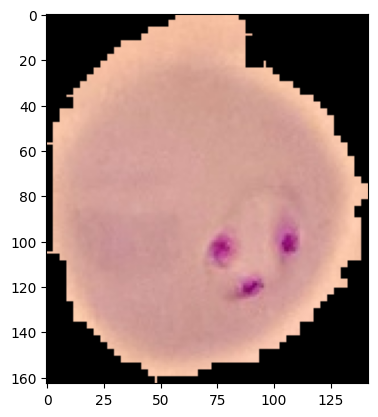

In [10]:
plt.imshow(cell_image_sample_read)

In [11]:
cell_image_sample_read.shape 

(163, 142, 3)

## Defining the correct shape of the image

In [12]:
correct_image_shape = (224, 224, 3)

## Defining the ImageGenerator and performing Data Augmentation

In [13]:
image_gen = ImageDataGenerator(rotation_range=20, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1, 
                               shear_range=0.1, 
                               zoom_range=0.1, 
                               horizontal_flip=True, 
                               fill_mode='nearest',
                               rescale=1./255)

In [14]:
train_image_gen = image_gen.flow_from_directory(train_dataset_location, 
                                                target_size=correct_image_shape[:2], 
                                                color_mode='rgb', 
                                                batch_size=16, 
                                                class_mode='binary')

test_image_gen = image_gen.flow_from_directory(test_dataset_location, 
                                                target_size=correct_image_shape[:2], 
                                                color_mode='rgb', 
                                                batch_size=16, 
                                                class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Defining the early stop

In [15]:
early_stop_loss = EarlyStopping(monitor='loss', patience=2)
early_stop_val_loss = EarlyStopping(monitor='val_loss', patience=2)

## Creating and training the model

In [16]:
mobilenetV3_model = load_model('mobilenetv3_model', compile=False)
inceptionV3_model = load_model('inceptionv3_model', compile=False)

In [17]:
mobilenetV3_model._name = 'model1'
inceptionV3_model._name = 'model2'

In [18]:
models = [mobilenetV3_model, inceptionV3_model]

In [19]:
model_input = Input(shape=correct_image_shape)

In [20]:
model_output = [model(model_input) for model in models]

In [21]:
x = Average()(model_output)

x = BatchNormalization()(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)

x = Dropout(0.3)(x)

x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)

x = Dropout(0.3)(x)

output_of_the_model = Dense(1, activation='sigmoid')(x)

In [22]:
model = Model(model_input, output_of_the_model)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model1 (Sequential)            (None, 1)            4150958     ['input_1[0][0]']                
                                                                                                  
 model2 (Sequential)            (None, 1)            23990894    ['input_1[0][0]']                
                                                                                                  
 average (Average)              (None, 1)            0           ['model1[0][0]',             

In [24]:
model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

In [25]:
model.fit(train_image_gen, validation_data=test_image_gen, epochs=30, callbacks=[early_stop_loss, early_stop_val_loss])

Epoch 1/30
625/625 [==============================] - 241s 308ms/step - loss: 0.6295 - accuracy: 0.6756 - val_loss: 0.3131 - val_accuracy: 0.9290
Epoch 2/30
625/625 [==============================] - 167s 268ms/step - loss: 0.3848 - accuracy: 0.8546 - val_loss: 0.2298 - val_accuracy: 0.9275
Epoch 3/30
625/625 [==============================] - 165s 264ms/step - loss: 0.3395 - accuracy: 0.8815 - val_loss: 0.2210 - val_accuracy: 0.9305
Epoch 4/30
625/625 [==============================] - 180s 288ms/step - loss: 0.3131 - accuracy: 0.8939 - val_loss: 0.1915 - val_accuracy: 0.9350
Epoch 5/30
625/625 [==============================] - 162s 259ms/step - loss: 0.3245 - accuracy: 0.8907 - val_loss: 0.1849 - val_accuracy: 0.9405
Epoch 6/30
625/625 [==============================] - 159s 255ms/step - loss: 0.3041 - accuracy: 0.9006 - val_loss: 0.2092 - val_accuracy: 0.9300
Epoch 7/30
625/625 [==============================] - 160s 255ms/step - loss: 0.3198 - accuracy: 0.8895 - val_loss: 0.2045 -

In [26]:
history_df = pd.DataFrame(model.history.history)

<Axes: >

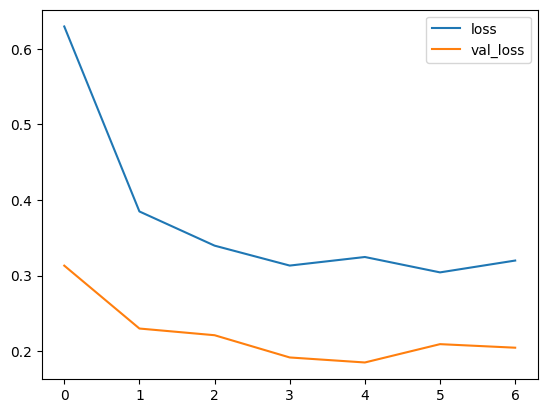

In [27]:
history_df[['loss', 'val_loss']].plot()

<Axes: >

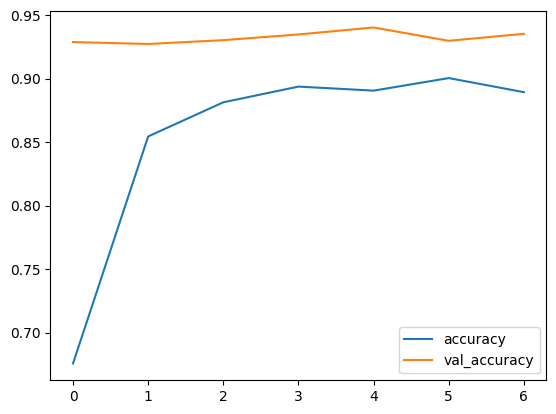

In [28]:
history_df[['accuracy', 'val_accuracy']].plot()

## Evaluating the model

In [29]:
model.evaluate(train_image_gen)[1]

625/625 [==============================] - 133s 212ms/step - loss: 0.1732 - accuracy: 0.9456


0.9455999732017517

In [30]:
model.evaluate(test_image_gen)[1]

125/125 [==============================] - 28s 224ms/step - loss: 0.2057 - accuracy: 0.9295


0.9294999837875366

## Predicting on a sample image

In [31]:
sample_img_load = image.load_img('./cell_images/test/parasitized/C100P61ThinF_IMG_20150918_145609_cell_149.png', target_size=correct_image_shape)

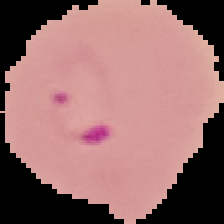

In [32]:
sample_img_load

In [33]:
sample_img_to_arr = image.img_to_array(sample_img_load) 

In [34]:
sample_img_to_arr = image.img_to_array(sample_img_load) / 255

In [35]:
sample_img_to_arr_expand_dim = np.expand_dims(sample_img_to_arr, 0) 

In [36]:
prediction = (model.predict(sample_img_to_arr_expand_dim) > 0.5).astype('int32')

1/1 [==============================] - 5s 5s/step


In [37]:
class_names = ['parasitized', 'uninfected']

In [38]:
pred_final_result = class_names[prediction[0][0]]

In [39]:
pred_final_result

'parasitized'

## Save the model

In [40]:
save_model(model, 'ensemble_learning_model')

INFO:tensorflow:Assets written to: ensemble_learning_model\assets
